BallTree implementation is inspired from https://youtu.be/E1_WCdUAtyE

Current implementation does:
1. BallTree construction (fit)
2. searching for one closest neighbor (query)
3. final tree visualization (non-interractive)

Further improvements:
1. introduce leaf size (currently it's one)?
2. allow to pass to query several points at a time (X instead of x)?
3. implement query radius method?
4. implement tree descriptive statistics (depth, num nodes, ratio of visited nodes, etc.)
5. optimize code (e.g. omit coppying data)
6. create interractive visualization
7. prettify & document code ;)

In [163]:
import operator
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.neighbors import BallTree
from scipy.spatial import distance_matrix

from optimizer import Optimizer

In [142]:
def pick_i(X):
    return np.random.randint(0, len(X))
       
        
def get_farthest_i(X, i):
    dists = distance_matrix(X[[i]], X)[0]
    i_max = np.argmax(dists)
    return i_max
    

def project_onto_line(X, w):
    w = np.expand_dims(w, axis=-1)
    proj = X @ w
    return proj[:, 0]
    

def dist2(x1, x2):
    return np.sum((x1 - x2)**2)


def dist_to_sphere(x, c, r):
    return np.sqrt(np.sum((c - x)**2)) - r


class BallTreeNode:
    def __init__(self, c, r):
        self.c = c
        self.r = r
        self._left = None
        self._right = None
        self.visited = False
        
    @property
    def left(self):
        return self._left
    
    @left.setter
    def left(self, ball_tree_node):
        if not isinstance(ball_tree_node, BallTreeNode):
            raise TypeError('invalid children data type')
        self._left = ball_tree_node
        
    @property
    def right(self):
        return self._right
        
    @right.setter
    def right(self, ball_tree_node):
        if not isinstance(ball_tree_node, BallTreeNode):
            raise TypeError('invalid children data type')
        self._right = ball_tree_node
    
    @property
    def is_leaf(self):
        return self.left is None and self.right is None
    
    def __str__(self):
        if self.is_leaf:
            return f'Leaf node at {self.c}'
        else:
            return f'Inner node with center at {self.c} and radius {self.r}'
    
    def __repr__(self):
        return f'BallTreeNode(c={self.c}, r={self.r})'


class BallTreeOptimizer(Optimizer):    
    def __repr__(self):
        return f'BallTreeOptimizer(k={self.k})'
        
        
    def fit(self, X: np.ndarray, y: np.ndarray):
        super().fit(X, y)
        self._root = self._build_ball_tree(X)
        return self
        
        
    def _build_ball_tree(self, X):
        # for leaf nodes return ball centered at this point with 0 radius 
        if len(X) == 1:
            return BallTreeNode(c=X[0], r=0.1)
        
        # pick random point from the dataset
        i0 = pick_i(X)
        x0 = X[i0]
        
        # pick farthers point from the previous one
        i1 = get_farthest_i(X, i0)
        x1 = X[i1]
        
        # again, pick farthers point from the previous one
        i2 = get_farthest_i(X, i1)
        x2 = X[i2]
        
        # vector x1-x2 is an approximation of PCA, i.e. dimention of the greatest spread
        # we project all the points onto that line and obtain a vector of numbers (1-D)
        proj = project_onto_line(X, x1-x2)
        
        # get indices of projection order to mask left and righ part
        order = np.argsort(proj)
        
        # split midpoint
        mi = len(proj) // 2
        
        # split to the left and right sub-parts
        X_left = X[order[:mi]]
        X_right = X[order[mi:]]        
        
        # calculate center and radius for the current ball;
        # center is a mean of all the data points;
        # radius determines by the farthers point from the center
        c = np.mean(X, axis=0)
        r = np.max(distance_matrix([c], X))
        
        # create corresponding node and construct its children by recursive calls
        node = BallTreeNode(c=c, r=r)
        node.left = self._build_ball_tree(X_left)
        node.right = self._build_ball_tree(X_right)
        
        return node
    
    
    def plot(self, x, y):                
        fig, ax = plt.subplots(figsize=(10,10))
        ax.scatter(self.X[:,0], self.X[:,1])
        ax.scatter([x[0]], [x[1]], marker='^', color='y')
        ax.scatter([y[0]], [y[1]], marker='s', color='r')
        
        node = self._root
        self.i = 1
        self._plot(node, ax=ax)        
        ax.axis('equal')  

    
    def _plot(self, node, ax, alpha=1):
        if node is not None:
            circle = plt.Circle(node.c, node.r, fill=False, alpha=alpha,
                                edgecolor='g' if node.visited else 'r')
            ax.add_patch(circle)
            
            if node.visited:
                ax.text(*node.c, self.i)
                self.i += 1
                
            self._plot(node.left, ax=ax, alpha=max(0.1, alpha-0.2))
            self._plot(node.right, ax=ax, alpha=max(0.1, alpha-0.2))

        
    def query(self, x):
        self._closest_node = None
        self._closest_dist = np.inf
        
        self._query(self._root, x)
        return self._closest_dist, self._closest_node.c
    
    
    def _query(self, node, x):
        # mark node as visited
        node.visited = True

        # if node is leaf we try to update current closest neighbor
        if node.is_leaf:
            dist = np.sqrt(dist2(node.c, x))
            if dist < self._closest_dist:
                self._closest_dist = dist
                self._closest_node = node
        else:  # otherwise visit children
            nodes_to_visit = []
            
            # create a queue of nodes to visit + precompute metrics
            if node.left is not None:
                center_to_left2 = dist2(x, node.left.c)
                sphere_to_left = dist_to_sphere(x, node.left.c, node.left.r)
                nodes_to_visit.append([center_to_left2, sphere_to_left, node.left])

            if node.right is not None:
                center_to_right2 = dist2(x, node.right.c)
                sphere_to_right = dist_to_sphere(x, node.right.c, node.right.r)
                nodes_to_visit.append([center_to_right2, sphere_to_right, node.right])
            
            # order queue by distance from the target to ball center;
            # i.e. visit closer ball at first
            nodes_to_visit.sort(key=operator.itemgetter(0))

            # iterate over queue and visit ball if it intersects 
            # with current smallest neighbor distance
            for _, sphere_to_node, node in nodes_to_visit:
                if sphere_to_node < self._closest_dist:
                    self._query(node, x)
                        
                        
    def get_k_nearest(self, X: np.ndarray) -> np.ndarray:
        pass

In [154]:
np.random.seed(42)

In [155]:
def test_ball_tree():
    for n in tqdm([10, 100, 1000, 10000, 100000]):
        for d in tqdm([1, 2, 3, 4, 10, 20, 30]): 
            X = np.random.randn(n, d)
            x = np.random.randn(d)
            
            sk_bt = BallTree(X)
            my_bt = BallTreeOptimizer(k=1)
            my_bt.fit(X, None)
            
            my_dist, my_point = my_bt.query(x)
            
            sk_dist, sk_idx = sk_bt.query([x])
            sk_point = X[sk_idx][0, 0]
            
            assert np.allclose(my_point, sk_point), (my_point, sk_point)

In [147]:
test_ball_tree()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [157]:
d = 2
X = np.random.randn(100, d)
x = np.random.randn(d)

sk_bt = BallTree(X)
my_bt = BallTreeOptimizer(k=1)
my_bt.fit(X, None)

BallTreeOptimizer(k=1)

In [158]:
my_dist, my_point = my_bt.query(x)
my_dist, my_point

(0.23969182006608647, array([0.25049285, 0.34644821]))

In [159]:
sk_dist, sk_idx = sk_bt.query([x])
sk_point = X[sk_idx][0, 0]
sk_dist, sk_point

(array([[0.23969182]]), array([0.25049285, 0.34644821]))

In [160]:
np.allclose(sk_point, my_point)

True

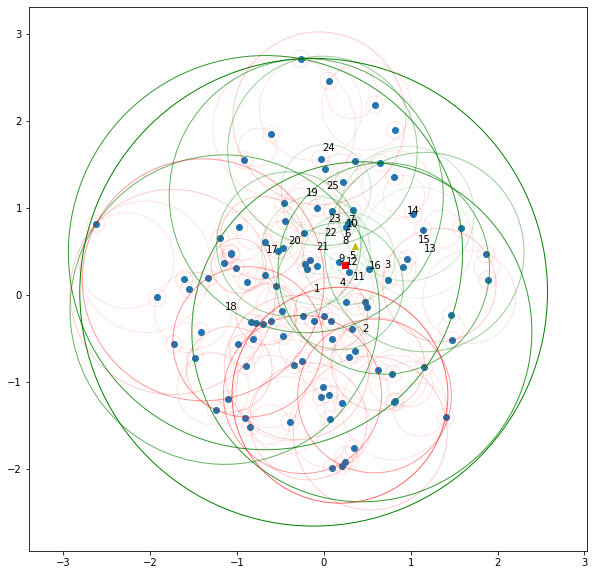

In [164]:
# green - visited balls
# number in vall center - order of visit
# yellow triangle - target point
# red square - nearest neighbor
my_bt.plot(x, my_point)